## Angelo Kelvakis
### Predicting Sexual Violence: Model evaluation

This script performs model tuning on the overview data of each media item, and then evaluates models with this new stacked model.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score
from sklearn import neighbors, tree
import pylab as plt
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [112]:
# This file MUST be in the cwd that this code is running in. Otherwise, pipe in file location
text_df = pd.read_csv('REDO_Overview_txtAnalysis')

### Text Model Tuning

In [175]:
# Split into 80-20 training and testing data
X_train, X_test, y_train, y_test = train_test_split(text_df['overview'], text_df['SV_binary'].values , test_size=0.20, random_state=0)
# Show the size of datasets
print('X Train Size:',X_train.shape)
print('X Test Size:',X_test.shape)

X Train Size: (7189,)
X Test Size: (1798,)


In [176]:
# Initialize vector of count of words
count_vect = CountVectorizer()
# transform data (necessary for tfidf transformation)
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)

# initialize tfidf
tfidf_transformer = TfidfTransformer()
# transform train and test data into tfidf form
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print('X Train Size:',X_train_tfidf.shape)
print('X Test Size:',X_test_tfidf.shape)

X Train Size: (7189, 26090)
X Test Size: (1798, 26090)


In [177]:
# KNN CLASSIFIER #

# Define the parameters to tune
parameters = { 
    'n_neighbors': [3,5,7,10,15,30],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
# Tune parameters  using Grid Search and a SVC model
model = GridSearchCV(neighbors.KNeighborsClassifier(), parameters, cv=5, n_jobs=-1).fit(X_train_tfidf, y_train)
# Predicting the Test set results
y_pred = model.predict(X_test_tfidf)
print(metrics.classification_report(y_test, y_pred,  digits=5))

              precision    recall  f1-score   support

           0    0.52975   0.26008   0.34888       719
           1    0.63183   0.84615   0.72345      1079

    accuracy                        0.61179      1798
   macro avg    0.58079   0.55312   0.53617      1798
weighted avg    0.59101   0.61179   0.57367      1798



In [178]:
# print out best parameters from grid search
print(model.best_params_)

{'metric': 'euclidean', 'n_neighbors': 30, 'weights': 'distance'}


In [179]:
# DECISION TREE CLASSIFIER #

# create a desicion tree object
treeclf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=3)
# Fit to training data
treeclf = treeclf.fit(X_train_tfidf, y_train)
# predict on test data
treepreds_test = treeclf.predict(X_test_tfidf)
# output stats
print(metrics.classification_report(y_test, treepreds_test))

              precision    recall  f1-score   support

           0       0.44      0.45      0.45       719
           1       0.63      0.61      0.62      1079

    accuracy                           0.55      1798
   macro avg       0.53      0.53      0.53      1798
weighted avg       0.55      0.55      0.55      1798



In [180]:
# SVC CLASSIFIER #

# Define the parameters to tune
parameters = { 
    'C': [1.0, 10],
    'gamma': [1, 'auto', 'scale']
}
# Tune yyperparameters  using Grid Search and a SVC model
model = GridSearchCV(SVC(kernel='rbf'), parameters, cv=5, n_jobs=-1).fit(X_train_tfidf, y_train)
# Predicting the Test set results
y_pred = model.predict(X_test_tfidf)
# print out stats
print(metrics.classification_report(y_test, y_pred,  digits=5))

              precision    recall  f1-score   support

           0    0.52065   0.40334   0.45455       719
           1    0.65431   0.75255   0.70000      1079

    accuracy                        0.61290      1798
   macro avg    0.58748   0.57794   0.57727      1798
weighted avg    0.60086   0.61290   0.60185      1798



In [182]:
# print out best parameters from grid search
print(model.best_params_)

{'C': 10, 'gamma': 'scale'}


## Final Text Model (NB)

In [147]:
# Re-initialize train test split and prepare tfidf format
X_train, X_test, y_train, y_test = train_test_split(full_media_df['overview'], full_media_df['SV_binary'].values , test_size=0.20, random_state=0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
# Run the NB model
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
print(metrics.classification_report(y_test, y_pred,  digits=5))

              precision    recall  f1-score   support

           0    0.58929   0.04590   0.08516       719
           1    0.60620   0.97868   0.74867      1079

    accuracy                        0.60567      1798
   macro avg    0.59774   0.51229   0.41692      1798
weighted avg    0.59944   0.60567   0.48334      1798



### Predict using text model and add prediction as a new column in the data

In [124]:
# Convert entire dataset to tfidf and predict
X_full_counts = count_vect.transform(full_media_df['overview'])
X_full_tfidf = tfidf_transformer.transform(X_full_counts)
# convert prediction into new row
text_df['predicted_from_overview'] = model.predict(X_full_tfidf)

### Clean data for numerical analysis

In [135]:
# Create dummy columns from itemType data
dummy_media = pd.get_dummies(text_df['itemType'].apply(pd.Series).stack()).sum(level=0)
# bind dummy data to rest of data
df = pd.concat([text_df, dummy_media], axis=1)
# Pull out non-numeric columns
df = df.iloc[:,4:]
# Drop over view column
df = df.drop(['overview'], axis = 1)
# Drop Class labels
df = df.drop(['SV_binary'], axis = 1)

In [136]:
# Min-max scale data
min_max_scaler = preprocessing.MinMaxScaler().fit(df)
df_norm = min_max_scaler.transform(df)
df_norm = pd.DataFrame(df_norm, columns=df.columns, index=df.index)

In [137]:
df_norm

,yearOfRelease,action,adventure,animation,anime,anthology,art,biography,childrens,comedy,...,selfhelp,thriller,travel,western,war,youngadult,predicted_from_overview,TV show,book,movie
0,0.376739,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.376532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.375493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.374455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.375909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8982,0.376324,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
8983,0.375493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8984,0.376116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8985,0.375701,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [138]:
# These functions help to tune the models parameters, similar to a manual version of grid search

def calc_params(X, y, clf, param_values, param_name, K):
    
    # Convert input to Numpy arrays
    X = np.array(X)
    y = np.array(y)

    # initialize training and testing score arrays with zeros
    train_scores = np.zeros(len(param_values))
    test_scores = np.zeros(len(param_values))
    
    # iterate over the different parameter values
    for i, param_value in enumerate(param_values):

        # set classifier parameters
        clf.set_params(**{param_name:param_value})
        
        # initialize the K scores obtained for each fold
        k_train_scores = np.zeros(K)
        k_test_scores = np.zeros(K)
        
        # create KFold cross validation
        cv = KFold(n_splits=K, shuffle=True, random_state=0)
        
        # iterate over the K folds
        j = 0
        for train, test in cv.split(X):
            # fit the classifier in the corresponding fold
            # and obtain the corresponding accuracy scores on train and test sets
            clf.fit(X[train], y[train])
            k_train_scores[j] = clf.score(X[train], y[train])
            k_test_scores[j] = clf.score(X[test], y[test])
            j += 1
            
        # store the mean of the K fold scores
        train_scores[i] = np.mean(k_train_scores)
        test_scores[i] = np.mean(k_test_scores)
        print(param_name, '=', param_value, "Train =", train_scores[i], "Test =", test_scores[i])
       
    # plot the training and testing scores in a log scale
    plt.plot(param_values, train_scores, label='Train', alpha=0.4, lw=2, c='b')
    plt.plot(param_values, test_scores, label='X-Val', alpha=0.4, lw=2, c='g')
    plt.legend(loc=7)
    plt.xlabel(param_name + " values")
    plt.ylabel("Mean cross validation accuracy")

    # return the training and testing scores on each parameter value
    return train_scores, test_scores

# function to output performance
def measure_performance(X, y, clf, show_accuracy=True, show_classification_report=True, show_confussion_matrix=True):
    y_pred = clf.predict(X)   
    if show_accuracy:
         print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y, y_pred)),"\n")
    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y, y_pred),"\n")
      
    if show_confussion_matrix:
        print("Confussion matrix")
        print(metrics.confusion_matrix(y, y_pred),"\n")

In [149]:
# Re-run train test split with new randon_state
X_train, X_test, y_train, y_test = train_test_split(df_norm, text_df['SV_binary'].values , test_size=0.20, random_state=2)

## Final Numeric Model

In [150]:
# create adaB obj
ab = AdaBoostClassifier()
# fit to train data
ab = ab.fit(X_train, y_train)
# output stats
measure_performance(X_test, y_test, ab, show_confussion_matrix=False, show_classification_report=True)

Accuracy:0.709 

Classification report
              precision    recall  f1-score   support

           0       0.75      0.45      0.56       749
           1       0.69      0.89      0.78      1049

    accuracy                           0.71      1798
   macro avg       0.72      0.67      0.67      1798
weighted avg       0.72      0.71      0.69      1798
 



n_estimators = 5 Train = 0.7142509532719592 Test = 0.7119217617447878
n_estimators = 10 Train = 0.7222493203697536 Test = 0.7179019998974064
n_estimators = 15 Train = 0.727500308950321 Test = 0.7233270712531807
n_estimators = 20 Train = 0.7297954410299086 Test = 0.7245786162061086
n_estimators = 25 Train = 0.7322297337658397 Test = 0.7256918533918311
n_estimators = 30 Train = 0.7328208627440738 Test = 0.7274994362192133
n_estimators = 35 Train = 0.7348726737733706 Test = 0.7287510779585424
n_estimators = 40 Train = 0.735255179663983 Test = 0.7295864413866394
n_estimators = 45 Train = 0.7354986337261538 Test = 0.7304207401643239
n_estimators = 50 Train = 0.7356724560691991 Test = 0.7291686144929893
n_estimators = 55 Train = 0.7359854753445552 Test = 0.728890160016957
n_estimators = 60 Train = 0.7361941347081441 Test = 0.728611995900128
n_estimators = 65 Train = 0.737063536631109 Test = 0.7295855703090293
n_estimators = 70 Train = 0.7370287117025545 Test = 0.7293069222601947
n_estimators

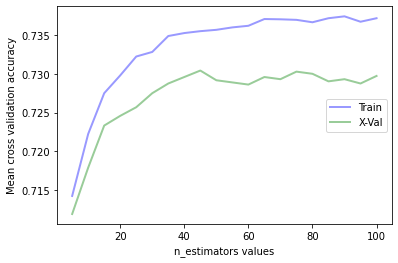

In [144]:
# Iterate over the number of random features by the n_estimators parameter
nest = range(5, 101, 5)
train_scores, test_scores = calc_params(X_train, y_train, ab, nest, 'n_estimators', 5)

learning_rate = 0.01 Train = 0.708721667562683 Test = 0.7087218097508428
learning_rate = 0.05 Train = 0.708721667562683 Test = 0.7087218097508428
learning_rate = 0.1 Train = 0.7086521144414867 Test = 0.7087218097508428
learning_rate = 0.2 Train = 0.7144943226902065 Test = 0.7112253835887042
learning_rate = 0.3 Train = 0.7235706059706857 Test = 0.7195723396079957
learning_rate = 0.4 Train = 0.7273264261473302 Test = 0.7219354763778271
learning_rate = 0.6 Train = 0.7312908331356293 Test = 0.7261093899262778
learning_rate = 0.7 Train = 0.734281405737262 Test = 0.7283343157153047
learning_rate = 0.8 Train = 0.7357072205378081 Test = 0.729029726007377
learning_rate = 0.9 Train = 0.7350116953718395 Test = 0.7297251362994495
learning_rate = 1.0 Train = 0.7356724560691991 Test = 0.7291686144929893
learning_rate = 1.3 Train = 0.734663996271798 Test = 0.7270818996847666
learning_rate = 1.5 Train = 0.7320906335694415 Test = 0.7279168759672591
learning_rate = 1.8 Train = 0.7262135278402329 Test = 

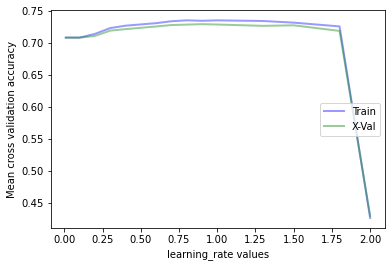

In [145]:
# iterate over learning rate parameter
lr = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0, 1.3, 1.5, 1.8, 2.0]
ab = AdaBoostClassifier()
train_scores, test_scores = calc_params(X_train, y_train, ab, lr, 'learning_rate', 5)

In [146]:
# Compare parameters to other ADABoost model
ab = AdaBoostClassifier(n_estimators=45,learning_rate=0.9)
ab = ab.fit(X_train, y_train)
measure_performance(X_test, y_test, ab, show_confussion_matrix=True, show_classification_report=True)

Accuracy:0.709 

Classification report
              precision    recall  f1-score   support

           0       0.75      0.45      0.56       749
           1       0.69      0.89      0.78      1049

    accuracy                           0.71      1798
   macro avg       0.72      0.67      0.67      1798
weighted avg       0.72      0.71      0.69      1798
 

Confussion matrix
[[337 412]
 [112 937]] 



### Compare other models

In [151]:
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.41      0.49       749
           1       0.66      0.81      0.72      1049

    accuracy                           0.64      1798
   macro avg       0.63      0.61      0.61      1798
weighted avg       0.64      0.64      0.63      1798



In [169]:
parameters = { 
    'n_neighbors': [3,5,7,10,15,30],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
# Tune yyperparameters  using Grid Search and a SVM model
model = GridSearchCV(neighbors.KNeighborsClassifier(), parameters, cv=5, n_jobs=-1).fit(X_train, y_train)
# Predicting the Test set results
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.48      0.56       749
           1       0.69      0.84      0.76      1049

    accuracy                           0.69      1798
   macro avg       0.68      0.66      0.66      1798
weighted avg       0.68      0.69      0.67      1798



In [170]:
print(model.best_params_)

{'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}


In [171]:
treeclf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=3)
treeclf = treeclf.fit(X_train, y_train)
treepreds_test = treeclf.predict(X_test)

print(metrics.classification_report(y_test, treepreds_test))

              precision    recall  f1-score   support

           0       0.58      0.63      0.61       749
           1       0.72      0.68      0.70      1049

    accuracy                           0.66      1798
   macro avg       0.65      0.66      0.65      1798
weighted avg       0.66      0.66      0.66      1798



In [172]:
parameters = { 
    'C': [1.0, 10],
    'gamma': [1, 'auto', 'scale']
}
# Tune yyperparameters  using Grid Search and a SVM model
model = GridSearchCV(SVC(kernel='rbf'), parameters, cv=5, n_jobs=-1).fit(X_train, y_train)
# Predicting the Test set results
y_pred = model.predict(X_test)

print(metrics.classification_report(y_test, y_pred,  digits=5))

              precision    recall  f1-score   support

           0    0.83708   0.39786   0.53937       749
           1    0.68724   0.94471   0.79566      1049

    accuracy                        0.71691      1798
   macro avg    0.76216   0.67129   0.66752      1798
weighted avg    0.74966   0.71691   0.68890      1798



In [173]:
print(model.best_params_)

{'C': 1.0, 'gamma': 'scale'}


min_samples_leaf = 1 Train = 0.9144179617791574 Test = 0.6924485314115425
min_samples_leaf = 2 Train = 0.8022673567806675 Test = 0.726943398344759
min_samples_leaf = 3 Train = 0.7731949925138496 Test = 0.7284727202689113
min_samples_leaf = 4 Train = 0.7619973632208609 Test = 0.7279171663264624
min_samples_leaf = 5 Train = 0.7546250769957406 Test = 0.7306984203491472
min_samples_leaf = 6 Train = 0.7501389671845182 Test = 0.7286115119681223
min_samples_leaf = 7 Train = 0.7478785512055832 Test = 0.727499049073609
min_samples_leaf = 8 Train = 0.7463832376977917 Test = 0.7268036387815366
min_samples_leaf = 9 Train = 0.7445053638854366 Test = 0.7272205945975767


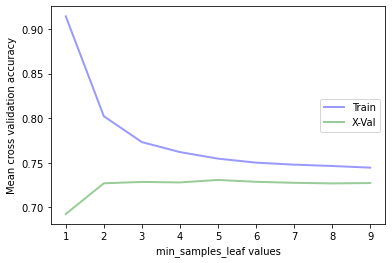

In [157]:
msl = range(1,10)
rf = RandomForestClassifier(random_state=33)
train_scores, test_scores = calc_params(X_train, y_train, rf, msl, 'min_samples_leaf', 5)

max_depth = 1 Train = 0.5946932854877509 Test = 0.5946590360268023
max_depth = 2 Train = 0.7024968627334328 Test = 0.7027405069478118
max_depth = 3 Train = 0.7135553132320943 Test = 0.7128949490080846
max_depth = 4 Train = 0.7194672741198301 Test = 0.7163720972548473
max_depth = 5 Train = 0.7256571935605806 Test = 0.7187369761798987
max_depth = 6 Train = 0.7324036951667594 Test = 0.7229099218643383
max_depth = 7 Train = 0.7405759087915774 Test = 0.7265260553831145
max_depth = 8 Train = 0.74603560510369 Test = 0.7298646055034683
max_depth = 9 Train = 0.7535818345917467 Test = 0.7302816581059094
max_depth = 10 Train = 0.760154477578913 Test = 0.7276395829280402


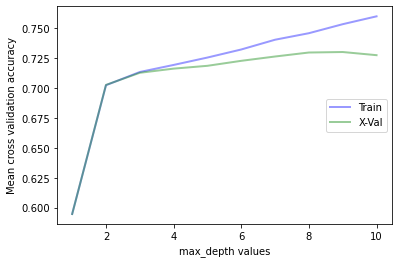

In [158]:
m_depth = [1,2,3,4,5,6, 7, 8, 9, 10]

rf = RandomForestClassifier(random_state=33)
train_scores, test_scores = calc_params(X_train, y_train, rf, m_depth, 'max_depth', 5)

n_estimators = 5 Train = 0.8863890998940983 Test = 0.6811796907287339
n_estimators = 10 Train = 0.9014120601629662 Test = 0.6817359221759907
n_estimators = 15 Train = 0.907323833624871 Test = 0.686188580559677
n_estimators = 20 Train = 0.9097928243234714 Test = 0.6856323491124203
n_estimators = 25 Train = 0.9112186330780231 Test = 0.687718386415835
n_estimators = 30 Train = 0.9126792123471784 Test = 0.6885532659119262
n_estimators = 35 Train = 0.9133399367685706 Test = 0.6892485794175975
n_estimators = 40 Train = 0.9137224668431614 Test = 0.6905005115161299
n_estimators = 45 Train = 0.9138963254621739 Test = 0.691752153255459
n_estimators = 50 Train = 0.9140702082651646 Test = 0.6907792563513656
n_estimators = 55 Train = 0.9141397492943719 Test = 0.6898051012240576
n_estimators = 60 Train = 0.9142440789761664 Test = 0.6910569365361889
n_estimators = 65 Train = 0.91417452585497 Test = 0.6914742794978335
n_estimators = 70 Train = 0.9142788615827593 Test = 0.6903617198169187
n_estimators 

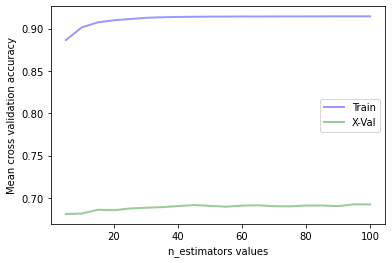

In [159]:
nest = range(5, 101, 5)
rf = RandomForestClassifier(random_state=33)
train_scores, test_scores = calc_params(X_train, y_train, rf, nest, 'n_estimators', 5)

In [161]:
rf = RandomForestClassifier(n_estimators=45, min_samples_leaf=5, max_depth=9)
rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.40      0.54       749
           1       0.69      0.94      0.79      1049

    accuracy                           0.71      1798
   macro avg       0.75      0.67      0.67      1798
weighted avg       0.74      0.71      0.69      1798



n_estimators = 5 Train = 0.7142509532719592 Test = 0.7119217617447878
n_estimators = 10 Train = 0.7222493203697536 Test = 0.7179019998974064
n_estimators = 15 Train = 0.727500308950321 Test = 0.7233270712531807
n_estimators = 20 Train = 0.7297954410299086 Test = 0.7245786162061086
n_estimators = 25 Train = 0.7322297337658397 Test = 0.7256918533918311
n_estimators = 30 Train = 0.7328208627440738 Test = 0.7274994362192133
n_estimators = 35 Train = 0.7348726737733706 Test = 0.7287510779585424
n_estimators = 40 Train = 0.735255179663983 Test = 0.7295864413866394
n_estimators = 45 Train = 0.7354986337261538 Test = 0.7304207401643239
n_estimators = 50 Train = 0.7356724560691991 Test = 0.7291686144929893
n_estimators = 55 Train = 0.7359854753445552 Test = 0.728890160016957
n_estimators = 60 Train = 0.7361941347081441 Test = 0.728611995900128
n_estimators = 65 Train = 0.737063536631109 Test = 0.7295855703090293
n_estimators = 70 Train = 0.7370287117025545 Test = 0.7293069222601947
n_estimators

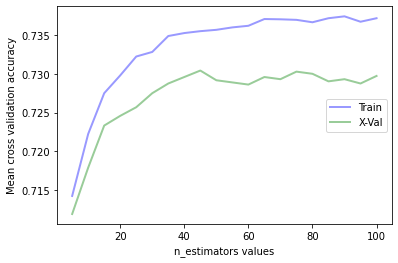

In [164]:
gb = GradientBoostingClassifier()
gb= gb.fit(X_train, y_train)
train_scores, test_scores = calc_params(X_train, y_train, ab, nest, 'n_estimators', 5)

learning_rate = 0.01 Train = 0.7091737568044646 Test = 0.7087218097508428
learning_rate = 0.05 Train = 0.7360203063191042 Test = 0.7262481816254889
learning_rate = 0.1 Train = 0.7460703091123537 Test = 0.7291680337745825
learning_rate = 0.2 Train = 0.7551118339702184 Test = 0.7291687112793903
learning_rate = 0.3 Train = 0.7632145851637582 Test = 0.729168324133786
learning_rate = 0.4 Train = 0.768778641387638 Test = 0.7255513195373997
learning_rate = 0.6 Train = 0.778411319407715 Test = 0.7197093891519866
learning_rate = 0.7 Train = 0.7829670367540845 Test = 0.7177619499749807
learning_rate = 0.8 Train = 0.7844623563078708 Test = 0.7148413235346782
learning_rate = 0.9 Train = 0.7863054837896003 Test = 0.7101119528301795
learning_rate = 1.0 Train = 0.7888441243453096 Test = 0.7070517603994568
learning_rate = 1.3 Train = 0.7829666981783903 Test = 0.707747073905128
learning_rate = 1.5 Train = 0.7752472267627641 Test = 0.7095561085285274
learning_rate = 1.8 Train = 0.7336904097709076 Test =

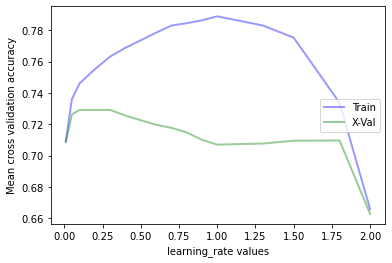

In [165]:
lr = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0, 1.3, 1.5, 1.8, 2.0]
gb = GradientBoostingClassifier()
train_scores, test_scores = calc_params(X_train, y_train, gb, lr, 'learning_rate', 5)

max_depth = 1 Train = 0.7136944617964488 Test = 0.7109471226854742
max_depth = 2 Train = 0.7350814177808831 Test = 0.7261084220622666
max_depth = 3 Train = 0.7460703091123537 Test = 0.7293072126193981
max_depth = 4 Train = 0.7572330651088316 Test = 0.7284731074145159
max_depth = 5 Train = 0.7706912071166675 Test = 0.7294466818234171
max_depth = 6 Train = 0.7879399216777683 Test = 0.7244390502156886
max_depth = 7 Train = 0.8093614244750083 Test = 0.7179005481013896
max_depth = 8 Train = 0.8338083429404186 Test = 0.7116411779679308


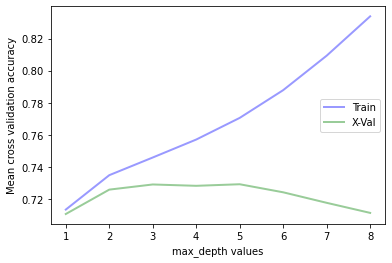

In [166]:
m_depth = [1,2,3,4,5,6,7,8]

gb = GradientBoostingClassifier()
train_scores, test_scores = calc_params(X_train, y_train, gb, m_depth, 'max_depth', 5)

In [167]:
gb = GradientBoostingClassifier(n_estimators=45, learning_rate=0.3,
                                 max_depth=5, random_state=0).fit(X_train, y_train)
y_pred = gb.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.47      0.58       749
           1       0.70      0.89      0.78      1049

    accuracy                           0.71      1798
   macro avg       0.72      0.68      0.68      1798
weighted avg       0.72      0.71      0.70      1798

